In [ ]:
!pip install scikit-learn pyyaml


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 1: Fresh unzip from Drive into a clean working folder

import os, shutil, zipfile
from pathlib import Path

ZIP_PATH  = "/content/drive/MyDrive/YOLO_PROJECT/YOLO.zip"  # your zip on Drive
DEST_DIR  = "/content/resume-dataset"                       # workspace in Colab

# 1) Clean any previous extraction
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR, exist_ok=True)

# 2) Unzip
assert os.path.exists(ZIP_PATH), f"ZIP not found at: {ZIP_PATH}"
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(DEST_DIR)

# 3) Show top-level contents
print("✅ Unzipped to:", DEST_DIR)
print("Top-level contents:", os.listdir(DEST_DIR)[:50])


✅ Unzipped to: /content/resume-dataset
Top-level contents: ['images', 'classes.txt', 'labels', 'notes.json']


In [ ]:
# Step 1: Build groups so all pages of the same resume stay together
from pathlib import Path
import re
from collections import defaultdict

# Base paths (after unzip)
root     = Path("/content/resume-dataset")
IMG_BASE = root / "images"
LBL_BASE = root / "labels"

# Collect images recursively
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}
images = [p for p in IMG_BASE.rglob("*") if p.is_file() and p.suffix in IMAGE_EXTS]

# Regex for your naming scheme:
# - single page: resume_001.jpg
# - multi page : resume_001_page_1.jpg (also tolerates '-', ' ', etc.)
pat_full    = re.compile(r'^(resume_\d+)[_\-\s]*page[_\-\s]*\d+$', re.I)
pat_single  = re.compile(r'^(resume_\d+)$', re.I)
pat_fallback= re.compile(r'(resume_\d+)', re.I)

def resume_id(path: Path) -> str:
    stem = path.stem
    m = pat_full.match(stem) or pat_single.match(stem) or pat_fallback.search(stem)
    return (m.group(1) if m else stem).lower()

# Build groups but keep ONLY images that have a matching YOLO .txt label
GROUPS = defaultdict(list)
PAIRS  = []
for ip in images:
    lp = LBL_BASE / f"{ip.stem}.txt"
    if lp.exists():
        rid = resume_id(ip)
        GROUPS[rid].append(ip)
        PAIRS.append(ip)

# Report
num_docs  = len(GROUPS)
num_pages = sum(len(v) for v in GROUPS.values())
print(f"Resumes (groups): {num_docs}")
print(f"Page images WITH labels: {len(PAIRS)}")
print(f"Total pages across groups: {num_pages}")

# Peek a few groups
for i, (rid, lst) in enumerate(GROUPS.items()):
    print(f"- {rid}: {len(lst)} page(s) → {[p.name for p in sorted(lst)[:3]]} ...")
    if i >= 4:
        break


Resumes (groups): 281
Page images WITH labels: 395
Total pages across groups: 395
- resume_024: 2 page(s) → ['5bfb0321-resume_024_page_2.png', '68cafc21-resume_024_page_1.png'] ...
- resume_106: 2 page(s) → ['5b4e202e-resume_106_page_1.png', 'faf65516-resume_106_page_2.png'] ...
- resume_167: 1 page(s) → ['28259974-resume_167_page_1.png'] ...
- resume_105: 3 page(s) → ['2581e459-resume_105_page_3.png', '8747cd7e-resume_105_page_1.png', '9a80bed4-resume_105_page_2.png'] ...
- resume_135: 2 page(s) → ['67f0011d-resume_135_page_2.png', 'e03210b8-resume_135_page_1.png'] ...


In [ ]:
import re

# Improved regex: look for 'resume_<digits>' anywhere in the filename
pat_resume = re.compile(r'(resume_\d+)', re.I)

def resume_id(path: Path) -> str:
    m = pat_resume.search(path.stem)
    return m.group(1).lower() if m else path.stem.lower()

# Rebuild groups with clean IDs
GROUPS = defaultdict(list)
PAIRS  = []
for ip in images:
    lp = LBL_BASE / f"{ip.stem}.txt"
    if lp.exists():
        rid = resume_id(ip)
        GROUPS[rid].append(ip)
        PAIRS.append(ip)

print(f"Resumes (groups): {len(GROUPS)}")
print(f"Page images WITH labels: {len(PAIRS)}")
print(f"Total pages across groups: {sum(len(v) for v in GROUPS.values())}")

# Peek again
for i,(rid,lst) in enumerate(GROUPS.items()):
    print(f"- {rid}: {len(lst)} page(s) → {[p.name for p in sorted(lst)[:3]]} ...")
    if i>=4: break


Resumes (groups): 281
Page images WITH labels: 395
Total pages across groups: 395
- resume_024: 2 page(s) → ['5bfb0321-resume_024_page_2.png', '68cafc21-resume_024_page_1.png'] ...
- resume_106: 2 page(s) → ['5b4e202e-resume_106_page_1.png', 'faf65516-resume_106_page_2.png'] ...
- resume_167: 1 page(s) → ['28259974-resume_167_page_1.png'] ...
- resume_105: 3 page(s) → ['2581e459-resume_105_page_3.png', '8747cd7e-resume_105_page_1.png', '9a80bed4-resume_105_page_2.png'] ...
- resume_135: 2 page(s) → ['67f0011d-resume_135_page_2.png', 'e03210b8-resume_135_page_1.png'] ...


In [ ]:
from pathlib import Path
import re, shutil

root     = Path("/content/resume-dataset")
IMG_BASE = root / "images"
LBL_BASE = root / "labels"

# Apply to all splits
splits = ["train", "val", "test"]

for split in splits:
    img_dir = IMG_BASE / split
    lbl_dir = LBL_BASE / split

    for img_path in img_dir.glob("*.*"):
        # find resume id and page number
        stem = img_path.stem
        ext  = img_path.suffix.lower()

        m = re.search(r'(resume_\d+)(?:[_\-\s]*page[_\-\s]*(\d+))?', stem, flags=re.I)
        if not m:
            continue
        rid, pg = m.group(1).lower(), m.group(2)

        new_name = f"{rid}_page_{pg}{ext}" if pg else f"{rid}{ext}"
        new_img_path = img_dir / new_name

        # rename image
        img_path.rename(new_img_path)

        # rename matching label
        old_lbl = lbl_dir / f"{stem}.txt"
        if old_lbl.exists():
            new_lbl = lbl_dir / f"{new_img_path.stem}.txt"
            old_lbl.rename(new_lbl)

print("✅ All images & labels renamed to clean format.")


✅ All images & labels renamed to clean format.


In [ ]:
# Step 3: Split by resume id into train/val/test and move paired files

import shutil
from sklearn.model_selection import train_test_split

# Reuse: root, IMG_BASE, LBL_BASE, GROUPS from previous steps

doc_ids = sorted(GROUPS.keys())

# 70/20/10 split on resume ids
train_docs, test_docs = train_test_split(doc_ids, test_size=0.10, random_state=42)
train_docs, val_docs  = train_test_split(train_docs, test_size=0.20, random_state=42)

def ensure_dirs():
    for split in ("train","val","test"):
        (IMG_BASE/split).mkdir(parents=True, exist_ok=True)
        (LBL_BASE/split).mkdir(parents=True, exist_ok=True)

def move_grouped(doc_list, split):
    for rid in doc_list:
        for ip in GROUPS[rid]:
            lp = LBL_BASE / f"{ip.stem}.txt"
            shutil.move(str(ip), str(IMG_BASE/split/ip.name))
            if lp.exists():
                shutil.move(str(lp), str(LBL_BASE/split/lp.name))

ensure_dirs()
move_grouped(train_docs, "train")
move_grouped(val_docs,   "val")
move_grouped(test_docs,  "test")

def count(split):
    n_img = len(list((IMG_BASE/split).glob("*")))
    n_lbl = len(list((LBL_BASE/split).glob("*")))
    return n_img, n_lbl

print("✅ Group-aware split complete:")
for s in ("train","val","test"):
    ni, nl = count(s)
    print(f"  {s}: {ni} images, {nl} labels")
print(f"Resumes per split — train:{len(train_docs)} | val:{len(val_docs)} | test:{len(test_docs)}")


✅ Group-aware split complete:
  train: 288 images, 288 labels
  val: 66 images, 66 labels
  test: 41 images, 41 labels
Resumes per split — train:201 | val:51 | test:29


In [ ]:
# Step 4: Build data.yaml using classes.txt (fallback to your known schema if missing)

from pathlib import Path
import yaml

root     = Path("/content/resume-dataset")
IMG_BASE = root / "images"
LBL_BASE = root / "labels"

classes_txt = root / "classes.txt"
if classes_txt.exists():
    with open(classes_txt, "r", encoding="utf-8") as f:
        class_names = [ln.strip() for ln in f if ln.strip()]
    print("Loaded classes from classes.txt:", class_names)
else:
    class_names = [
        "PERSONAL_INFO","SUMMARY","CONTACT","EXPERIENCE","EDUCATION",
        "SKILLS","PROJECTS/certifications","LANGUES","OTHERS"
    ]
    print("⚠️ classes.txt not found — using fallback:", class_names)

data_yaml = {
    "train": str((IMG_BASE / "train").resolve()),
    "val":   str((IMG_BASE / "val").resolve()),
    "test":  str((IMG_BASE / "test").resolve()),
    "nc": len(class_names),
    "names": class_names,
}

out_path = root / "data.yaml"
with open(out_path, "w", encoding="utf-8") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("✅ Wrote:", out_path)


Loaded classes from classes.txt: ['CONTACT', 'EDUCATION', 'EXPERIENCE', 'LANGUES', 'OTHERS', 'PERSONAL_INFO', 'PROJECTS/certifications', 'SKILLS', 'SUMMARY']
✅ Wrote: /content/resume-dataset/data.yaml


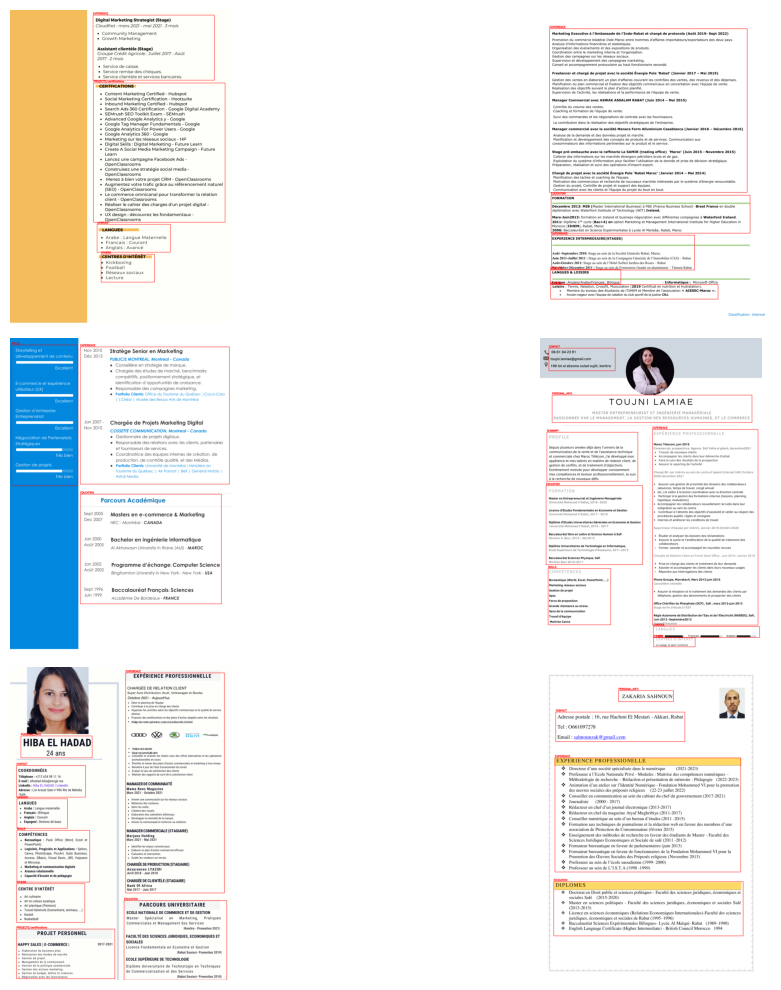

In [ ]:
# Step 5: Visual sanity check before training — overlay YOLO labels on validation images
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

root     = Path("/content/resume-dataset")
IMG_BASE = root / "images"
LBL_BASE = root / "labels"

# Load class names
with open(root / "classes.txt", "r", encoding="utf-8") as f:
    CLASS_NAMES = [ln.strip() for ln in f if ln.strip()]

def draw_gt(img_path: Path, lbl_path: Path):
    im = cv2.imread(str(img_path))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    h, w = im.shape[:2]
    if lbl_path.exists():
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, xc, yc, bw, bh = map(float, parts)
                x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
                cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)
                label = CLASS_NAMES[int(cls)] if int(cls) < len(CLASS_NAMES) else str(int(cls))
                cv2.putText(im, label, (x1, max(0, y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    return im

val_imgs = list((IMG_BASE / "val").glob("*"))[:6]
assert val_imgs, "No images in images/val. Did the split run correctly?"

plt.figure(figsize=(14, 10))
for i, ip in enumerate(val_imgs[:6], 1):
    lp = LBL_BASE / "val" / f"{ip.stem}.txt"
    plt.subplot(3, 2, i)
    plt.imshow(draw_gt(ip, lp))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Step 6: Install YOLOv8, load a pretrained checkpoint, and train on your dataset
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path

data_yaml = str(Path("/content/resume-dataset/data.yaml").resolve())

# Choose a model size:
#  - yolov8n.pt (fastest, least accurate)
#  - yolov8s.pt (good trade-off)
#  - yolov8m.pt / l / x (larger, slower, more accurate)
model = YOLO("yolov8s.pt")

results = model.train(
    data=data_yaml,
    epochs=100,
    imgsz=640,
    batch=16,          # reduce if you hit OOM (try 8 or 4)
    optimizer="auto",
    patience=20,       # early stop if no improvement
    device=0,          # GPU if available
    workers=2,         # Colab-friendly
    cache=True,        # speed up dataloader
    pretrained=True,
)

print("✅ Training complete. Best weights at:", results.save_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/resume-dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01

In [ ]:
# Step 7: Re-run validation WITH plots, then preview predictions on a few test images

from ultralytics import YOLO
from pathlib import Path
import random

root = Path("/content/resume-dataset")
data_yaml = str((root / "data.yaml").resolve())
weights   = "runs/detect/train/weights/best.pt"

# 1) Validation with plots (confusion matrix, PR curves, F1 curve, results.png)
model = YOLO(weights)
val_results = model.val(data=data_yaml, plots=True, save_json=True)  # saves plots under runs/detect/val*

print("✅ Validation done. Plots saved under:", val_results.save_dir)

# 2) Predict on a few random test images and save visualizations
test_imgs = list((root / "images" / "test").glob("*"))
sample = random.sample(test_imgs, k=min(8, len(test_imgs))) if test_imgs else []
if sample:
    preds = model.predict(sample, save=True, conf=0.25, iou=0.7, imgsz=640)
    print("✅ Predictions saved under:", preds[0].save_dir)
else:
    print("⚠️ No images found in images/test — check your split.")


Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2602.4±513.6 MB/s, size: 452.7 KB)
val: Scanning /content/resume-dataset/labels/val.cache... 66 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 66/66 23543.5it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.58it/s 8.6s
                   all         66        394      0.429      0.581      0.538      0.397
               CONTACT         51         51      0.689      0.588      0.642      0.424
             EDUCATION         50         50       0.39       0.78      0.674      0.598
            EXPERIENCE         60         63      0.616      0.794      0.782      0.615
               LANGUES         46         47      0.341       0.66      0.514      0.326
                OTHERS         34         4

In [ ]:
from ultralytics import YOLO
from pathlib import Path

root = Path("/content/resume-dataset")
data_yaml = str((root / "data.yaml").resolve())
weights   = "runs/detect/train/weights/best.pt"  # from your training

model = YOLO(weights)
print("Loaded:", weights)


Loaded: runs/detect/train/weights/best.pt


In [ ]:
# Evaluate strictly on images/test with plots & JSON
metrics = model.val(data=data_yaml, split='test', plots=True, save_json=True)
print("✅ Test evaluation saved to:", metrics.save_dir)


Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1391.6±1240.0 MB/s, size: 402.5 KB)
val: Scanning /content/resume-dataset/labels/test... 41 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 41/41 159.2it/s 0.3s
val: New cache created: /content/resume-dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.68it/s 4.4s
                   all         41        223      0.506      0.505      0.532      0.398
               CONTACT         29         29      0.692      0.586      0.716      0.544
             EDUCATION         29         30      0.542      0.833      0.739       0.62
            EXPERIENCE         37         38       0.87      0.789      0.857      0.725
               LANGUES         21         21      0.435      0.571      

In [ ]:
# Predict on ALL test images; saves annotated images in a new runs/detect/predict*
test_imgs_dir = root / "images" / "test"
preds = model.predict(source=str(test_imgs_dir), save=True, conf=0.25, iou=0.7, imgsz=640)
print("✅ Predictions saved under:", preds[0].save_dir)



image 1/41 /content/resume-dataset/images/test/0524e61b-resume_160_page_2.png: 640x480 2 EXPERIENCEs, 83.9ms
image 2/41 /content/resume-dataset/images/test/07a75ccd-resume_263_page_2.png: 640x512 2 EDUCATIONs, 1 OTHERS, 75.4ms
image 3/41 /content/resume-dataset/images/test/128a3e2c-resume_160_page_3.png: 640x480 1 EDUCATION, 1 EXPERIENCE, 3 LANGUESs, 13.4ms
image 4/41 /content/resume-dataset/images/test/1b79bdb4-resume_034_page_2.png: 640x480 2 EXPERIENCEs, 12.1ms
image 5/41 /content/resume-dataset/images/test/1be54d66-resume_094_page_1.png: 640x480 2 EDUCATIONs, 1 PERSONAL_INFO, 12.1ms
image 6/41 /content/resume-dataset/images/test/211a713d-resume_139_page_1.png: 640x480 2 EDUCATIONs, 1 EXPERIENCE, 12.1ms
image 7/41 /content/resume-dataset/images/test/2930ccca-resume_281_page_1.png: 640x480 1 CONTACT, 2 EDUCATIONs, 1 EXPERIENCE, 1 LANGUES, 1 OTHERS, 1 PERSONAL_INFO, 12.1ms
image 8/41 /content/resume-dataset/images/test/2f2426a7-resume_103_page_1.png: 640x480 2 EDUCATIONs, 1 LANGUES, 

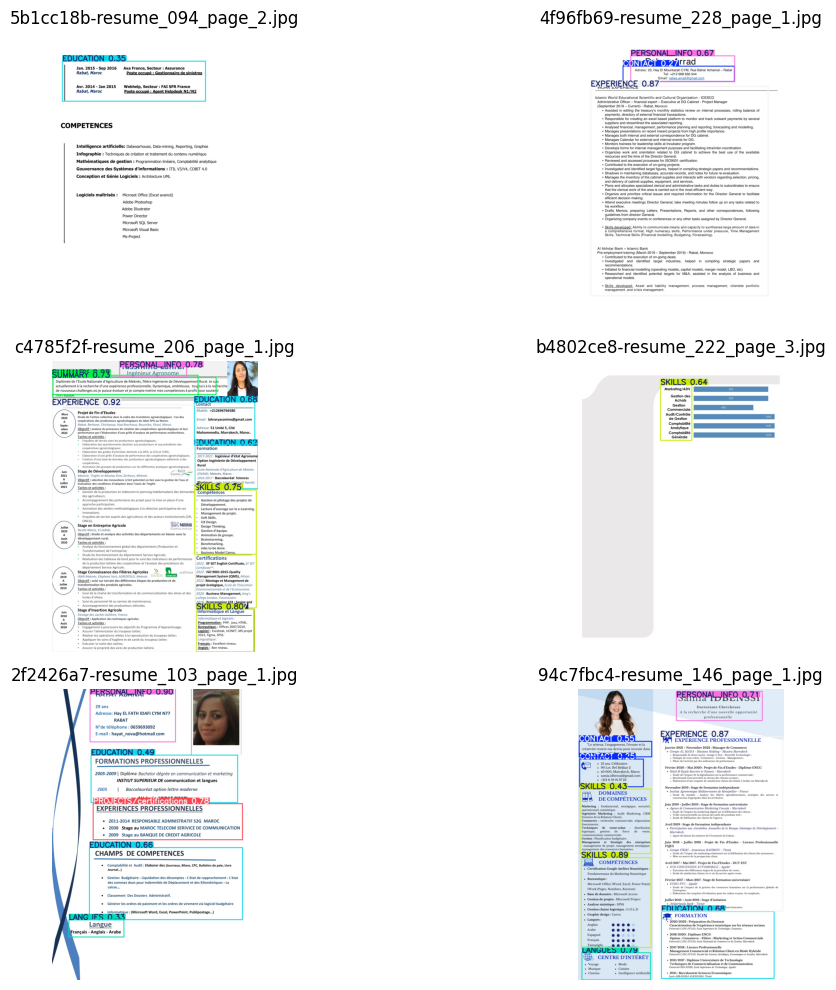

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2

out_dir = Path(preds[0].save_dir)
samples = random.sample(list(out_dir.glob("*.jpg")) + list(out_dir.glob("*.png")), k=min(6, len(list(out_dir.glob('*')))))

plt.figure(figsize=(14,10))
for i, p in enumerate(samples, 1):
    im = cv2.imread(str(p))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(3,2,i); plt.imshow(im); plt.axis('off'); plt.title(p.name)
plt.tight_layout(); plt.show()


In [ ]:
# Step 1: Enumerate resume_<id> present in images/test and show page counts

from pathlib import Path
import re
from collections import defaultdict

root     = Path("/content/resume-dataset")
TEST_IMG = root / "images" / "test"

assert TEST_IMG.exists(), "images/test not found — did the split run?"

# tolerate UUID-like prefixes before resume_### and optional _page_N after
pat_resume = re.compile(r'(resume_\d+)', re.I)

def resume_id_from_name(name: str) -> str | None:
    m = pat_resume.search(Path(name).stem)
    return m.group(1).lower() if m else None

ids = defaultdict(list)
for p in TEST_IMG.iterdir():
    if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}:
        rid = resume_id_from_name(p.name)
        if rid:
            ids[rid].append(p.name)

# Show a compact summary (sorted by id)
summary = [(rid, len(names)) for rid, names in sorted(ids.items())]
print(f"Found {len(summary)} resume IDs in test split.")
for rid, n in summary[:30]:  # show first 30 for brevity
    print(f"- {rid}: {n} page(s)")

# Keep the mapping for the next step
TEST_RESUME_PAGES = {rid: sorted(names) for rid, names in ids.items()}


Found 29 resume IDs in test split.
- resume_010: 1 page(s)
- resume_034: 3 page(s)
- resume_043: 1 page(s)
- resume_047: 1 page(s)
- resume_068: 1 page(s)
- resume_070: 1 page(s)
- resume_077: 1 page(s)
- resume_079: 1 page(s)
- resume_092: 1 page(s)
- resume_094: 2 page(s)
- resume_103: 1 page(s)
- resume_122: 1 page(s)
- resume_139: 2 page(s)
- resume_146: 1 page(s)
- resume_148: 1 page(s)
- resume_149: 1 page(s)
- resume_150: 1 page(s)
- resume_159: 1 page(s)
- resume_160: 3 page(s)
- resume_195: 2 page(s)
- resume_206: 1 page(s)
- resume_215: 1 page(s)
- resume_222: 3 page(s)
- resume_228: 2 page(s)
- resume_252: 2 page(s)
- resume_263: 2 page(s)
- resume_266: 1 page(s)
- resume_270: 1 page(s)
- resume_281: 1 page(s)


In [ ]:
def predict_resume(resume_id: str,
                   split: str = "test",
                   conf: float = 0.25,
                   iou: float = 0.7,
                   imgsz: int = 640,
                   exts=(".png", ".jpg", ".jpeg"),
                   show: bool = True,
                   save_annotated: bool = True):

    root = Path("/content/resume-dataset")
    img_dir = root / "images" / split
    rid = resume_id.lower().strip()
    if not rid.startswith("resume_"):
        rid = f"resume_{rid}"

    pat = re.compile(rf"^{re.escape(rid)}(?:_page_(\d+))?$", re.I)
    pages = []
    for ext in exts:
        for p in img_dir.glob(f"*{ext}"):
            m = pat.match(p.stem)
            if m:
                page_num = int(m.group(1)) if m.group(1) else 1
                pages.append((page_num, p))
    if not pages:
        raise FileNotFoundError(f"No pages found for {rid} in images/{split}")

    pages_sorted = [p for _, p in sorted(pages, key=lambda x: x[0])]
    preds = _MODEL.predict(pages_sorted, conf=conf, iou=iou, imgsz=imgsz, verbose=False)

    # display each page bigger (width=12, height=16)
    if show:
        for ip, pr in zip(pages_sorted, preds):
            im = cv2.imread(str(ip))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            for box in pr.boxes:
                x1,y1,x2,y2 = map(int, box.xyxy[0].cpu().numpy())
                cls_id = int(box.cls[0])
                label = _CLASS_NAMES.get(cls_id, str(cls_id))
                cv2.rectangle(im, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(im, label, (x1, max(0,y1-6)),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,0), 2)
            plt.figure(figsize=(12,16))
            plt.imshow(im)
            plt.axis('off')
            plt.title(f"{rid} — {ip.name}")
            plt.show()

            if save_annotated:
                out_dir = Path("resume_predictions") / rid
                out_dir.mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str(out_dir/ip.name), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

    return pages_sorted, preds


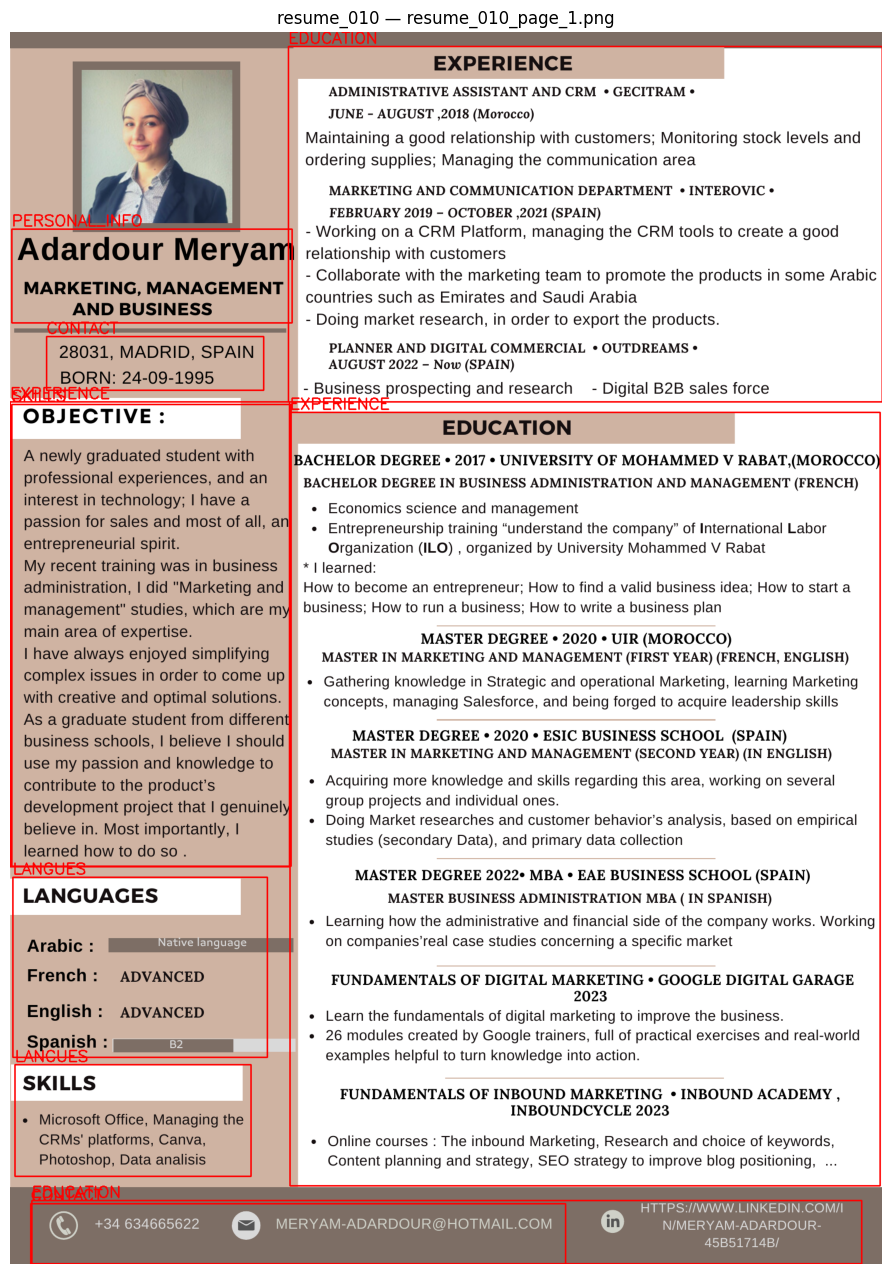

In [ ]:


pages, preds = predict_resume("resume_010", split="test", conf=0.25, iou=0.7, imgsz=640, show=True)